# Description of baseline-extraction method

- using B-spline basis functions and peak-extraction

In [49]:
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as plt
import scipy
import scipy.signal as signal
import pystan

In [2]:
## autoreload magic for development
%load_ext autoreload
%autoreload 1
import sys
sys.path.insert(0, "../")
%aimport pypillometry
pp=pypillometry
#import pypillometry as pp

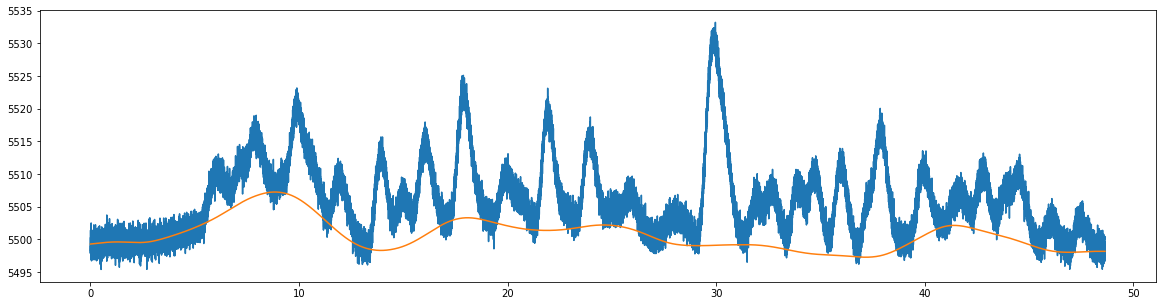

In [78]:
## generate and plot dataset together with the (ground-truth) baseline
fs=1000
tx,sy,baseline,event_onsets,_=pp.get_dataset(ntrials=20, fs=fs)
plt.figure(figsize=(20,5))
plt.plot(tx,sy,label="raw signal")
plt.plot(tx,baseline, label="real baseline")

## use down-sampled and filtered data for efficiency

In [75]:
fsd=10 ## new sampling rate after downsampling
dsfac=int(fs/fsd) # calculate downsampling factor

syc=pp.butter_lowpass_filter(sy, 2, fs, order=2)
syd=pp.downsample(syc, dsfac)

# z-scale for easier model-fitting
symean,sysd=np.mean(syd),np.std(syd)
syd=(syd-symean)/sysd
txd=pp.downsample(tx, dsfac)

# downsample baseline for comparison
based=pp.downsample(baseline,dsfac)
based=(based-symean)/sysd

## Extract lower peaks and build B-spline basis functions

- also extract "prominence" of the peak which is defined here:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html

In [5]:
peaks_ix=signal.find_peaks(-syd)[0]
prominences=signal.peak_prominences(-syd, peaks_ix)[0]
peaks=txd[peaks_ix]
knots=np.concatenate( ([txd.min()], peaks, [txd.max()]) ) ## peaks as knots
#knots=np.linspace(txd.min(), txd.max(), int(txd.shape[0]*0.1) ) ## alternatively give more knots for more flexibility
B=pp.bspline(txd, knots, 3)

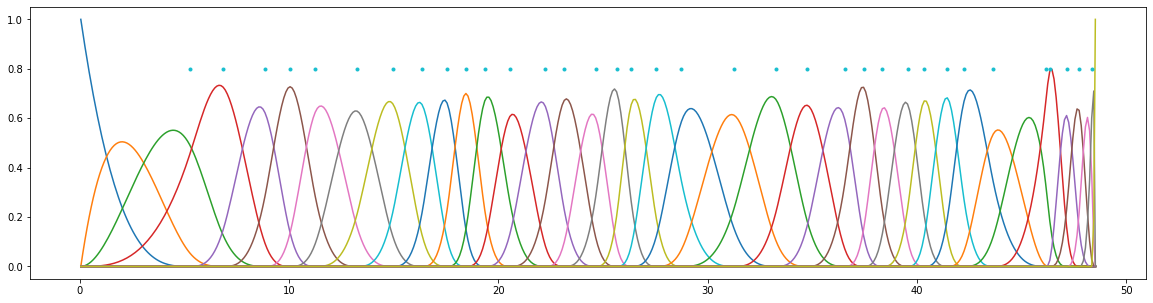

In [6]:
## those are the basis-functions (dots are the local minima)
plt.figure(figsize=(20,5))
plt.plot(txd, B);
plt.plot(peaks, 0.8+np.zeros_like(peaks), ".")

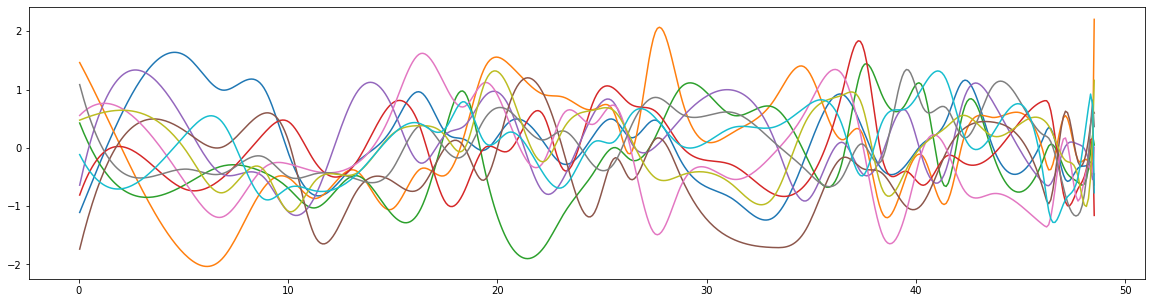

In [7]:
## thes are example functions using random coefficients with the B-spline basis functions
plt.figure(figsize=(20,5))
for i in range(10):
    coef=np.random.randn(B.shape[1])
    sig=np.dot(B,coef)
    plt.plot(txd, sig)
    #plt.xlim(0,1)

## Staying "below the signal"

- the next step is to estimate the coefficients with which the B-spline basis-functions in the matrix $B$ must be multiplied to give the baseline-function
- criteria:
    1. the curve has to be (almost) completely below the pupil-signal
    2. it should go through the high-prominence peaks with high probability
    3. it should go through the lower-prominence peaks with lower probability
- to stay below the signal, we use the Asymmetric Laplace distribution https://en.wikipedia.org/wiki/Asymmetric_Laplace_distribution
- when centering this distribution on the data-curve, we can achieve that the probability that the estimated baseline lies above the curve is minimal (used instead of a hard cutoff to achieve better estimation performance)
- this asymetric distribution has parameters $\mu$ (peak location), $\lambda$ (inverse variance, "wideness") and $\kappa$ (assymetry parameter)
    - because the distribution will be centered at the signal $s$, we have $\mu=0$
    - we can set the asymmetry parameter $\kappa$ to a meaningful value as follows:
        1. we specify the probability $p_a$ that the baseline-curve can take on values above the pupil signal, e.g., $p_a=0.05$
        2. using the properties of the distribution and its CDF, we can set $$\kappa=\frac{\sqrt{p_a}}{\sqrt{1-p_a}}$$
    - that way, no matter what $\lambda$ is chosen, the negative part of the distribution will integrate to $p_a$

kappa= 0.22941573387056177
Proportion negative= 0.052898137321281825


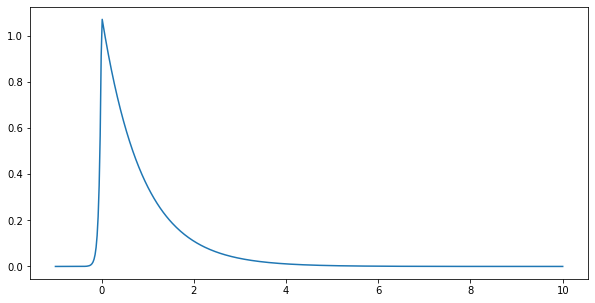

In [13]:
pa=0.05
kappa=np.sqrt(pa)/np.sqrt(1-pa)
print("kappa=",kappa)

plt.figure(figsize=(10,5))
y=np.linspace(-1,10,500)

py=pp.p_asym_laplac_kappa(y,0,5,kappa)
plt.plot(y,py)
propneg=np.sum(py[y<=0])/np.sum(py)
print("Proportion negative=",propneg)

In [104]:
SY.shape

(500, 486)

In [125]:
py=pp.p_asym_laplac_kappa(-1*(Y-SY), 0, 1, 0.2)

(800, 486) (800, 486)


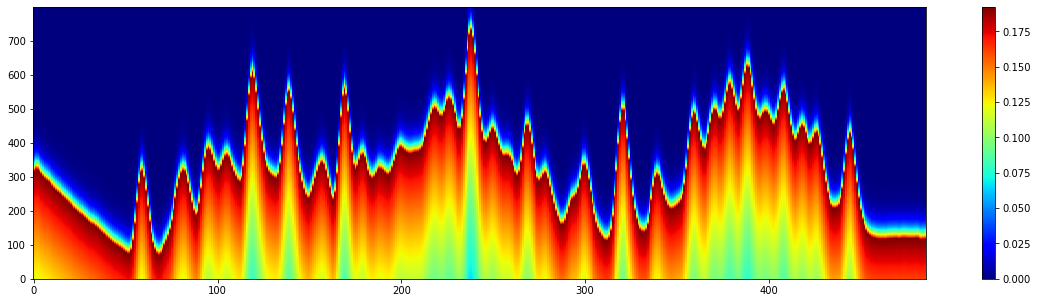

In [130]:
print(X.shape, Y.shape)
SY=np.tile(syd, (ny,1))

plt.figure(figsize=(20,5))
plt.imshow(py, origin='lower', cmap="jet", aspect="auto")
#plt.plot(txd, syd*500)
plt.colorbar()

In [106]:
ny=800
x=txd
pad=0.5
y=np.linspace(syd.min()-pad, syd.max()+pad, ny)
[X,Y]=np.meshgrid(x,y)

### prominence of the peaks

- Now we need to map the prominence of the peaks to the width of this distribution
- We have to use a mapping from the prominence to the parameter $\lambda$
- We start by specifying how far below the signal the baseline can be and call that parameter $\lambda_{sig}$
- Our signal is z-transformed, so 1 unit is one SD which is pretty large.
- When setting $\lambda_{sig}=1$, the curve is allowed to go quite far away from the signal (which is what we want)

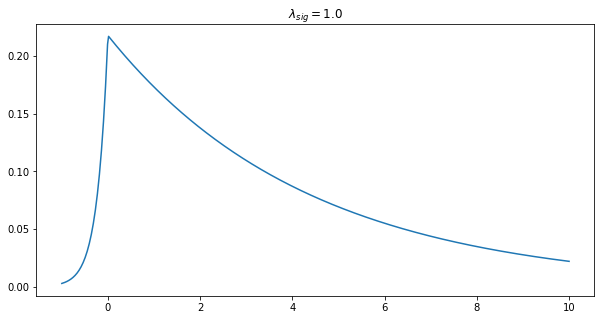

In [20]:
plt.figure(figsize=(10,5))

lam_sig=1.0
y=np.linspace(-1,10,500)
py=pp.p_asym_laplac_kappa(y,0,lam_sig,kappa)
plt.plot(y,py);
plt.title(r"$\lambda_{sig}=$%s"%lam_sig);

- next, for the highest-prominence peaks, we want that the baseline-curve "snugglest" tightly against the signal
- if the highest-prominence peak can achieve $\lambda_{max}=100$, it looks like that (note the scales); as noted above, $\lambda$ is an inverse variance, so higher values mean a narrower distribution

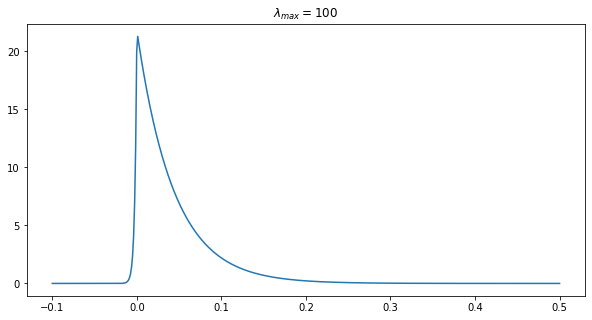

In [24]:
plt.figure(figsize=(10,5))
y=np.linspace(-.1,.5,500)
py=pp.p_asym_laplac_kappa(y, 0, 100, kappa)
plt.plot(y,py)
plt.title(r"$\lambda_{max}=100$");

- the signal should be closer to the lower peaks than to the rest of the signal but can still go away if the prominence is very low
- we therefore set the lower boundary for $\lambda$ for any peak to be the same as for the rest of the signal $\lambda_{min}=\lambda_{sig}$
- now we have to define the mapping 
$$\text{prominence}\rightarrow \lambda$$
- such that $\lambda \in [\lambda_{min},\lambda_{max}]$ and higher prominence is associated with higher $\lambda$
- we start by mapping the (strictly positive) prominence $\rho_i$ into the interval [0,1] and then map it linearly into $[\lambda_{min},\lambda_{max}]$
$$\lambda_i=\lambda_{min}+\frac{\rho_i-\min_i\rho_i}{\max_i(\rho_i-\min_i\rho_i)}\left(\lambda_{max}-\lambda_{min}\right) $$

In [85]:
## implements transformation detailed above
def prominence_to_lambda(w, lam_min=1, lam_max=100):
    w2=lam_min+((w-np.min(w))/(np.max(w-np.min(w))))*(lam_max-lam_min)
    return w2

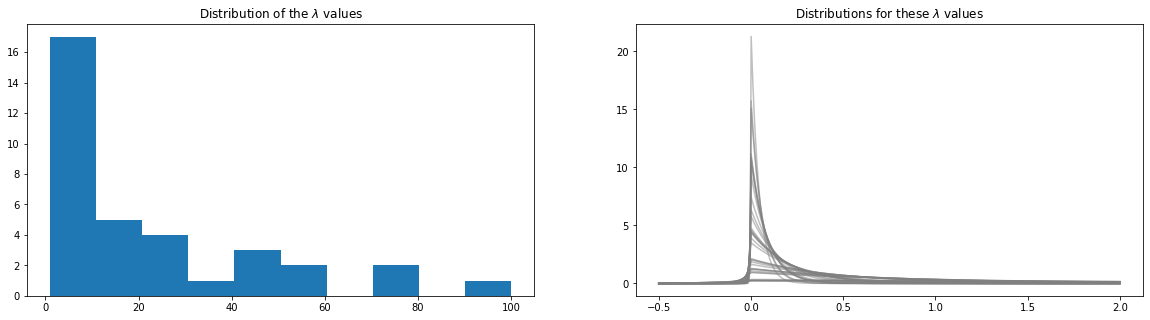

In [84]:
# convert
w=prominence_to_lambda(prominences)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(w);
plt.title(r"Distribution of the $\lambda$ values");
plt.subplot(122)
y=np.linspace(-0.5,2,500)
for i,cw in enumerate(w):
    py=pp.p_asym_laplac_kappa(y, 0, cw, kappa)
    plt.plot(y,py, color="grey", alpha=0.5)
plt.title(r"Distributions for these $\lambda$ values");

## Specifying the Stan model

- putting it all together in a Stan model
- basis-functions and parameter transformations are done outside of Stan
- Stan estimates the coefficients for the B-matrix

In [40]:
%%writefile baseline.stan

// Stan model for pupil-baseline estimation
//
functions{
    // asymmetric laplace function with the mu, sigma, tau parametrization
    real skew_double_exponential_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau) + log1m(tau)
        - log(sigma)
        - 2 * ((y < mu) ? (1 - tau) * (mu - y) : tau * (y - mu)) / sigma;
    }
    
    // zero-centered asymmetric laplace function with the mu, lambda, kappa parametrization
    real skew_double_exponential2_lpdf(real y, real lam, real kappa) {
      return log(lam) - log(kappa+1/kappa)
        + ((y<0) ? (lam/kappa) : (-lam*kappa))*(y);
    }
}
data{ 
  int<lower=1> n; // number of timepoints in the signal
  vector[n] sy;   // the pupil signal
    
  int<lower=1> ncol; // number of basis functions (columns in B)
  matrix[n,ncol] B;  // spline basis functions
    
  int<lower=1> npeaks;          // number of lower peaks in the signal
  int<lower=1> peakix[npeaks];  // index of the lower peaks in sy
  vector<lower=0>[npeaks] lam_prominences; // lambda-converted prominence values
    
  real<lower=0> lam_sig;    // lambda for the signal where there is no peak
  real<lower=0,upper=1> pa; // proportion of allowed distribution below 0
}

transformed data{
    vector[n] lam;       // lambda at each timepoint
    real<lower=0> kappa; // calculated kappa from pa
    kappa=sqrt(pa)/sqrt(1-pa);
    
    lam=rep_vector(lam_sig, n); 
    for(i in 1:npeaks){
        lam[peakix[i]]=lam_prominences[i];
    }
}
parameters {
    vector[ncol] coef; // coefficients for the basis-functions
}

transformed parameters{
    
}

model {
    {
    vector[n] d;
        
    coef ~ normal(0,5);
    d=sy-(B*coef); // center at estimated baseline
    for( i in 1:n ){
        d[i] ~ skew_double_exponential2(lam[i], kappa);
    }
    }
}

Overwriting baseline.stan


In [42]:
## fit the model (with caching)
#sm = pystan.StanModel('baseline.stan')
sm = pp.StanModel_cache(open('baseline.stan').read())

Using cached StanModel


In [43]:
## put the data for the model together
data={
    'n':syd.shape[0],
    'sy':syd,
    'ncol':B.shape[1],
    'B':B,
    'npeaks':peaks_ix.shape[0],
    'peakix':peaks_ix,
    'lam_sig':1,
    'pa':0.05,
    'lam_prominences':w
}

### Full model vs. VB-optimization

- once the model is implemented in Stan, we can sample draws from the full posterior distribution
- this is good because also uncertainty about the measures is being estimated
- but it takes a long time
- as an alternative, Stan implements a "Variational Bayes" optimizer that estimates the posterior mean of the parameters
- this is fast but comes at the price of reduced control over estimation uncertainty

In [44]:
%time 
## full sampling first
fit = sm.sampling(data=data, iter=2000, warmup=1000, chains=4, n_jobs=4)

## extract coefficients
c=fit.extract("coef")["coef"]
## put a few random draws together
sig=np.column_stack([np.dot(B, c[i,:]) for i in np.random.permutation(np.arange(1,4000))[1:100]])
## and calculate the posterior mean signal
meansig=np.dot(B, np.mean(c,axis=0))

In [45]:
## variational optimization
opt=sm.vb(data=data)
vbc=opt["mean_pars"]
meansigvb=np.dot(B, vbc)

### Comparison of full bayes and VB

- the grey curves show posterior draws; it can nicely be seen that the variance is larger between knots and very small at the highest-prominence knots (length of the error-bars is proportional to its $\lambda$ value)
- the posterior mean and the VB estimate correspond quite well, so we go with VB from here on

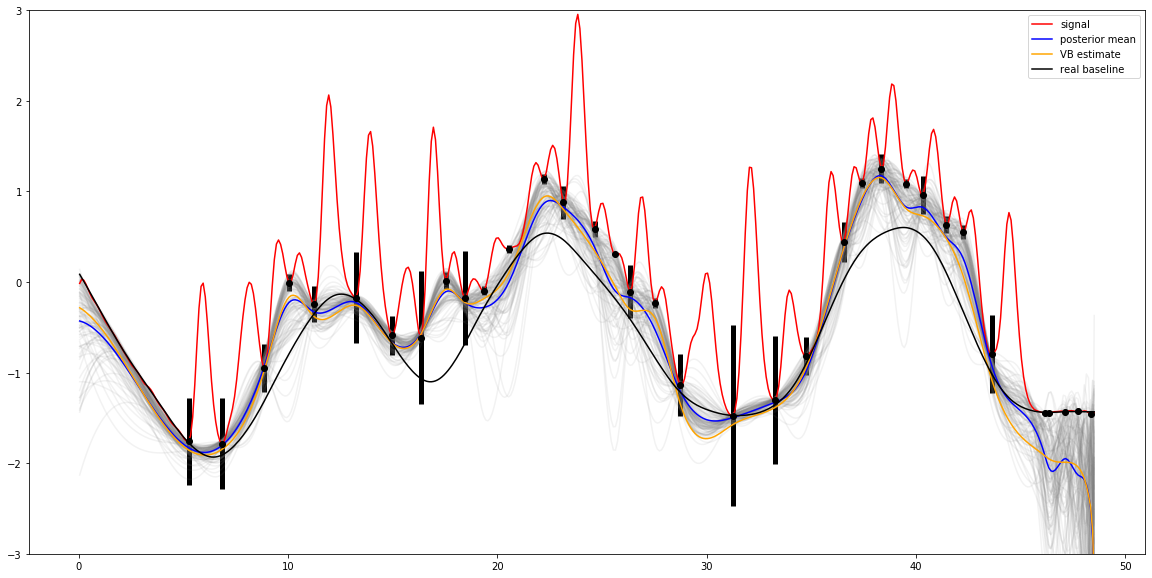

In [47]:
plt.figure(figsize=(20,10))
plt.plot(txd, sig, color="grey", alpha=0.1)
plt.plot(txd, syd, color="red", label="signal")
plt.plot(txd, meansig, color="blue", label="posterior mean")
plt.plot(txd, meansigvb, color="orange", label="VB estimate")
plt.plot(txd, based, color="black", label="real baseline")
plt.errorbar(peaks, syd[peaks_ix], yerr=[w/100,w/100], fmt="o", color="black", elinewidth=5)
plt.ylim(-3,3)
plt.legend();

## account for pupil-events and iterate the procedure

- it still looks like our baseline is too close to the signal
- that is because the buildup of the PRFs that are close together can mimic baseline-fluctuations
- one way to improve on this is to use the baseline curve extracted from the procedure so far and estimate the PRFs riding on top
- then we can remove this estimated PRF signal from the original curve and run the baseline estimation again

## fit single-trial PRF model to the baseline-subtracted data

In [48]:
# new "signal"
syd2=syd-meansigvb

# prepare stimulus and response-regressors
h=pp.pupil_kernel(fs=fsd) ## pupil kernel

# event-onsets for each event
x1 = np.zeros((event_onsets.size, syd.size), dtype=np.float) # onsets

# event-onsets as indices of the txd array
evon_ix=np.argmin(np.abs(np.tile(event_onsets, (syd.size,1)).T-txd), axis=1)
x1[ np.arange(event_onsets.size), evon_ix ]=1

# convolve with PRF to get single-trial regressors
for i in range(event_onsets.size):
    x1[i,]=np.convolve(x1[i,], h, mode="full")[0:x1[i,].size]

In [54]:
## we use a non-negative least squares solver to force the PRF-coefficients to be positive
coef=scipy.optimize.nnls(x1.T, syd2)[0]
pred=np.dot(x1.T, coef)  ## predicted signal
resid=syd2-pred         ## residual

### the modeled signal captures most PRFs well (except the spurious ones, of course)

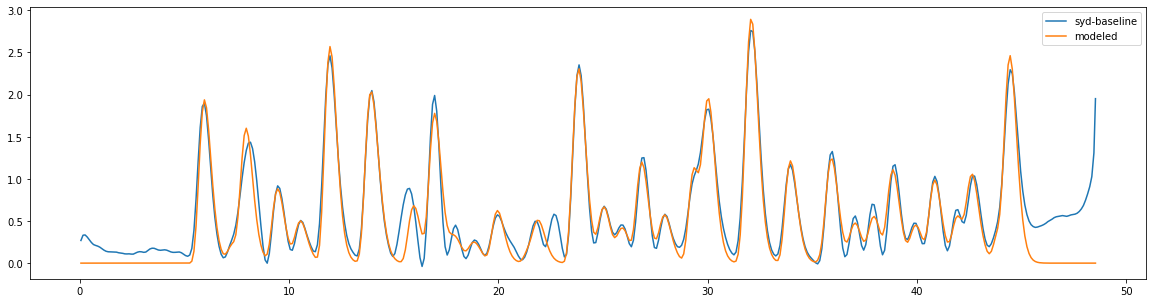

In [58]:
plt.figure(figsize=(20,5))
#plt.plot(txd, syd, label="syd")
plt.plot(txd, syd2, label="syd-baseline")
plt.plot(txd, pred, label="modeled")
plt.legend();

- now we can remove the predicted PRF signal from the original signal and repeat the baseline estimation

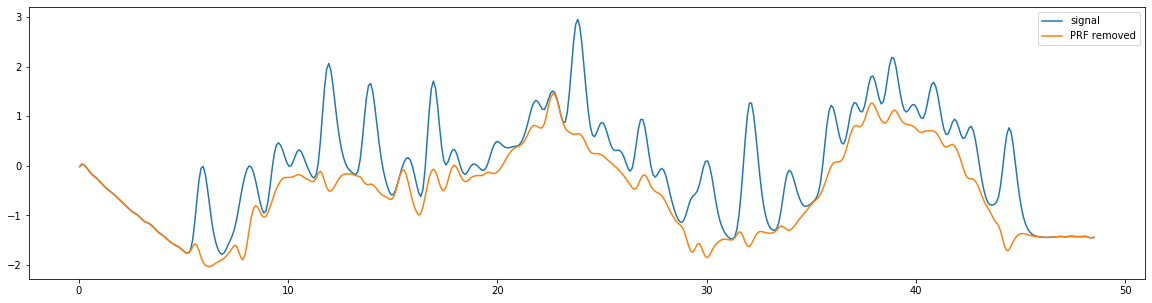

In [63]:
plt.figure(figsize=(20,5))
plt.plot(txd, syd, label="signal")
plt.plot(txd, syd-pred, label="PRF removed")
plt.legend();

### repeat baseline estimation

- using exactly the same procedure as above

In [64]:
## get new peaks
syd3=syd-pred
peaks2_ix=signal.find_peaks(-syd3)[0]
prominences2=signal.peak_prominences(-syd3, peaks2_ix)[0]
peaks2=txd[peaks2_ix]
knots2=np.concatenate( ([txd.min()], peaks2, [txd.max()]) ) ## peaks as knots
B2=pp.bspline(txd, knots2, 3)

- we seem to get fewer high-prominence peaks, which is good as it means that the signal is probably smoother

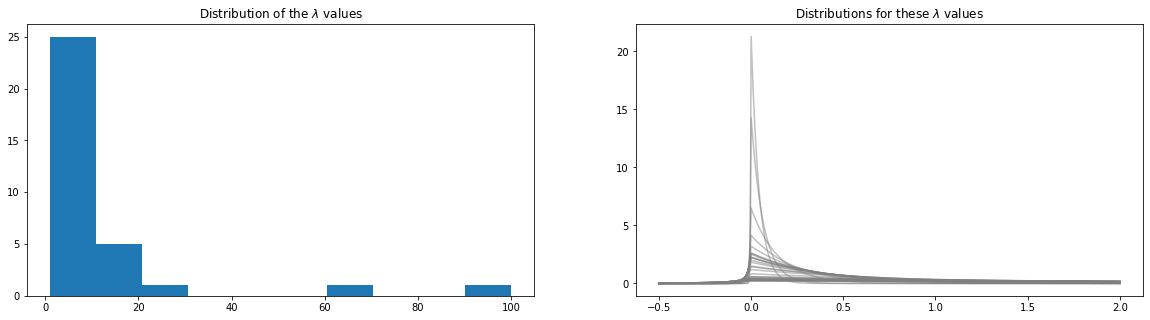

In [82]:
w2=prominence_to_lambda(prominences2)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(w2);
plt.title(r"Distribution of the $\lambda$ values");
plt.subplot(122)
y=np.linspace(-0.5,2,500)
for i,cw in enumerate(w2):
    py=pp.p_asym_laplac_kappa(y, 0, cw, kappa)
    plt.plot(y,py, color="grey", alpha=0.5)
plt.title(r"Distributions for these $\lambda$ values");

In [67]:
data2={
    'n':syd3.shape[0],
    'sy':syd3,
    'ncol':B2.shape[1],
    'B':B2,
    'npeaks':peaks2_ix.shape[0],
    'peakix':peaks2_ix,
    'lam_sig':1,
    'pa':0.05,
    'lam_prominences':w2
}

In [68]:
##  variational optimization
opt=sm.vb(data=data2)
vbc2=opt["mean_pars"]
meansigvb2=np.dot(B2, vbc2)

## comparison

- the repeated VB estimate is smoother and follows the signal less smoothly
- it is also closer to the real baseline

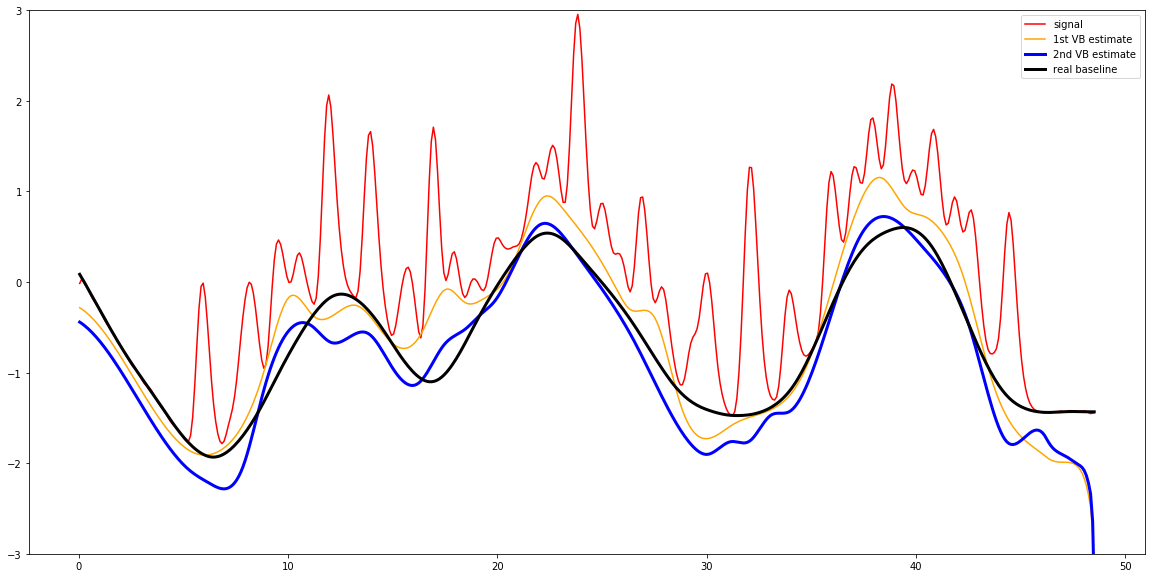

In [73]:
plt.figure(figsize=(20,10))
plt.plot(txd, syd, color="red", label="signal")
plt.plot(txd, meansigvb, color="orange", label="1st VB estimate")
plt.plot(txd, meansigvb2, color="blue",linewidth=3, label="2nd VB estimate")
plt.plot(txd, based, color="black", linewidth=3, label="real baseline")
#plt.errorbar(peaks, syd[peaks_ix], yerr=[w/100,w/100], fmt="o", color="black", elinewidth=5)
plt.ylim(-3,3)
plt.legend();